<a href="https://colab.research.google.com/github/Dvaalmeyda/deteksi-kemiripan-judul-skripsi/blob/main/Semantic_Scoring_FINAL_Skripsi_Diva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skripsi

- Diva Putra Almeyda
- 2010501053
- S1 Teknik Elektro Universitas Tidar

## Labeling - Semantic Similarity Scoring

### Dependencies

In [ ]:
import pandas as pd
import re
import nltk
import torch
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
# Download NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load Dataset

In [ ]:
# URL dataset
judul_dataset_url = 'https://docs.google.com/spreadsheets/d/155gUL7xq9yjZkSPtCQHUtJdJVwWQO_Ycho5MHbt5SVI/export?gid=0&format=csv'

In [ ]:
pra_judul_df = pd.read_csv(judul_dataset_url)

In [ ]:
# Merge
combinations = list(product(pra_judul_df['judul 1'], pra_judul_df['judul 1']))

# Df baru
judul_df = pd.DataFrame(combinations, columns=['judul 1', 'judul 2'])

In [ ]:
judul_df_copy = judul_df.copy()

In [ ]:
judul_df

,judul 1,judul 2
0,analisis gangguan tidak seimbang pada jaring d...,analisis gangguan tidak seimbang pada jaring d...
1,analisis gangguan tidak seimbang pada jaring d...,analisis kegagalan operasi rele jarak pada sal...
2,analisis gangguan tidak seimbang pada jaring d...,analisis pengaruh pembebanan terhadap posisi p...
3,analisis gangguan tidak seimbang pada jaring d...,analisis pengaruh putaran rotor terhadap ayuna...
4,analisis gangguan tidak seimbang pada jaring d...,analisis pengurangan harmonik pada converter a...
...,...,...
39995,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem pentanahan gedung dan genset
39996,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem pentanahan pada transformator ...
39997,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem proteksi kilang minyak terhada...
39998,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem proteksi petir di kawasan rsud...


### Preprocess

#### Filtering

In [ ]:
# Filtering & Casefolding
def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  text = text.lower()
  return text

In [ ]:
# Coba Filtering
judul_df['judul 1 filter'] = judul_df['judul 1'].apply(remove_punctuation)
judul_df[['judul 1', 'judul 1 filter']]

NameError: name 'judul_df' is not defined

#### Tokenize nltk & Stopwords removal

In [ ]:
# Helper Function Tokenisasi nltk
def tokenize_nltk_stopwords(text):
    # Tokenisasi
    tokens = word_tokenize(text)
    # Stopwords removal
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Fungsi untuk menggabungkan token kembali menjadi kalimat
def join_tokens(tokens):
    return ' '.join(tokens)

In [ ]:
# Coba Stopwords removal
judul_df['judul 1 processed'] = judul_df['judul 1 filter'].apply(tokenize_nltk_stopwords).apply(join_tokens)
judul_df[['judul 1', 'judul 1 processed']]

,judul 1,judul 1 processed
0,analisis gangguan tidak seimbang pada jaring d...,analisis gangguan seimbang jaring distribusi 2...
1,analisis gangguan tidak seimbang pada jaring d...,analisis gangguan seimbang jaring distribusi 2...
2,analisis gangguan tidak seimbang pada jaring d...,analisis gangguan seimbang jaring distribusi 2...
3,analisis gangguan tidak seimbang pada jaring d...,analisis gangguan seimbang jaring distribusi 2...
4,analisis gangguan tidak seimbang pada jaring d...,analisis gangguan seimbang jaring distribusi 2...
...,...,...
39995,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem proteksi petir kawasan rumah s...
39996,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem proteksi petir kawasan rumah s...
39997,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem proteksi petir kawasan rumah s...
39998,evaluasi sistem proteksi petir pada kawasan ru...,evaluasi sistem proteksi petir kawasan rumah s...


#### Main Preprocess

In [ ]:
# Main Function - Preprocessing
def preprocess_text(text):
    text = remove_punctuation(text)
    tokens = tokenize_nltk_stopwords(text)
    processed_text = join_tokens(tokens)
    return processed_text

In [ ]:
# judul terindikasi mirip
judul_df['judul 1 processed'] = judul_df['judul 1'].apply(preprocess_text)
judul_df['judul 2 processed'] = judul_df['judul 2'].apply(preprocess_text)

# TEST

In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModel

In [ ]:
# Muat model
model_name = "indobenchmark/indobert-large-p2"
model = AutoModel.from_pretrained(model_name)

# Menampilkan jumlah lapisan di encoder
num_layers = len(model.encoder.layer)
print(f"Jumlah layer: {num_layers}")

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Jumlah layer: 24


In [ ]:
# Muat model
model_name1 = "indolem/indobert-base-uncased"
model1 = AutoModel.from_pretrained(model_name1)

# Menampilkan jumlah lapisan di encoder
num_layers1 = len(model1.encoder.layer)
print(f"Jumlah layer: {num_layers1}")

Jumlah layer: 12


In [ ]:
from bert_score import score

In [ ]:
cands=['persentase pembebanan transformator tenaga kapasitas 30mva 60mva gardu induk 150kv']
refs=['perancangan homepage universitas tidar magelang berbasis html']

In [ ]:
P, R, F1 = score(cands,
                 refs,
                 lang="id",
                 verbose=True,
                 model_type='indobenchmark/indobert-large-p2',
                 num_layers= 24,
                 #rescale_with_baseline=True
                 )

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.67 sentences/sec


In [ ]:
# Cetak hasil
print(f"Precision: {P.mean().item()}")
print(f"Recall: {R.mean().item()}")
print(f"F1 Score: {F1.mean().item()}")

Precision: 0.33685070276260376
Recall: 0.35013747215270996
F1 Score: 0.3433656096458435


# BERT SCORE

In [ ]:
import pandas as pd
from bert_score import score

In [ ]:
# Fungsi untuk memuat CSV dan menghitung BERTScore
def calculate_bertscore(df):

    # Ambil kolom "judul 1 processed" dan "judul 2 processed"
    cands = df['judul 1 processed'].tolist()
    refs = df['judul 2 processed'].tolist()

    # Hitung BERTScore
    P, R, F1 = score(cands,
                 refs,
                 lang="id",
                 verbose=True,
                 model_type='indobenchmark/indobert-large-p2',
                 num_layers= 24,
                 )

    # Masukkan nilai Precision, Recall, dan F1 ke dalam tabel
    df['Precision'] = P.numpy()
    df['Recall'] = R.numpy()
    df['F1'] = F1.numpy()

    return df

In [ ]:
csv_file = 'https://docs.google.com/spreadsheets/d/1YAuYZa_LFqxqOpiMgFr-imZRoiIaNSZGDscOvY30tb8/export?gid=287899900&format=csv'

In [ ]:
cek_df = pd.read_csv(csv_file)

In [ ]:
cek_df

,id,judul 1,judul 2,judul 1 processed,judul 2 processed
0,10560,Transmisi data 8-bit serial termultipleksi den...,Transmisi data serial 8-bit termultipleksi mel...,transmisi data 8bit serial termultipleksi radi...,transmisi data serial 8bit termultipleksi radi...
1,10079,pengujian tahanan isolasi dan tan delta pada t...,pengujian halangan isolasi dan tan delta pada ...,pengujian tahanan isolasi tan delta transforma...,pengujian halangan isolasi tan delta transform...
2,10474,studi kelayakan aliran sungai guna memilih tur...,studi tentang kelayakan aliran sungai untuk me...,studi kelayakan aliran sungai memilih turbin a...,studi kelayakan aliran sungai memilih turbin a...
3,10043,analisa nilai tahanan pentanahan tower sutt ga...,Analisa nilai tahanan pentanahan menara sutt G...,analisa nilai tahanan pentanahan tower sutt ga...,analisa nilai tahanan pentanahan menara sutt g...
4,10436,sistem monitoring data pergerakan tanah pada l...,sistem monitoring pergerakan tanah di lereng r...,sistem monitoring data pergerakan tanah lereng...,sistem monitoring pergerakan tanah lereng rawa...
...,...,...,...,...,...
5463,10491,studi perbaikan faktor daya pada saluran trans...,studi tentang perbaikan faktor daya di saluran...,studi perbaikan faktor daya saluran transmisi ...,studi perbaikan faktor daya saluran transmisi ...
5464,10494,studi potensi daya pembangkit listrik tenaga a...,studi tentang potensi daya pembangkit listrik ...,studi potensi daya pembangkit listrik tenaga a...,studi potensi daya pembangkit listrik tenaga a...
5465,10499,studi sistem pentanahan peralatan di gardu induk,studi tentang sistem pentanahan untuk peralata...,studi sistem pentanahan peralatan gardu induk,studi sistem pentanahan peralatan gardu induk
5466,10500,studi sistem proteksi rele pada bay trafo i ka...,studi tentang sistem proteksi rele untuk bay t...,studi sistem proteksi rele bay trafo i kapasit...,studi sistem proteksi rele bay trafo i kapasit...


In [ ]:
result_df = calculate_bertscore(cek_df)

calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/86 [00:00<?, ?it/s]

done in 6.21 seconds, 880.99 sentences/sec


In [ ]:
result_df

,id,judul 1,judul 2,judul 1 processed,judul 2 processed,Precision,Recall,F1
0,10560,Transmisi data 8-bit serial termultipleksi den...,Transmisi data serial 8-bit termultipleksi mel...,transmisi data 8bit serial termultipleksi radi...,transmisi data serial 8bit termultipleksi radi...,0.968665,0.981198,0.974891
1,10079,pengujian tahanan isolasi dan tan delta pada t...,pengujian halangan isolasi dan tan delta pada ...,pengujian tahanan isolasi tan delta transforma...,pengujian halangan isolasi tan delta transform...,0.981110,0.982051,0.981580
2,10474,studi kelayakan aliran sungai guna memilih tur...,studi tentang kelayakan aliran sungai untuk me...,studi kelayakan aliran sungai memilih turbin a...,studi kelayakan aliran sungai memilih turbin a...,0.984941,0.984941,0.984941
3,10043,analisa nilai tahanan pentanahan tower sutt ga...,Analisa nilai tahanan pentanahan menara sutt G...,analisa nilai tahanan pentanahan tower sutt ga...,analisa nilai tahanan pentanahan menara sutt g...,0.991916,0.991916,0.991916
4,10436,sistem monitoring data pergerakan tanah pada l...,sistem monitoring pergerakan tanah di lereng r...,sistem monitoring data pergerakan tanah lereng...,sistem monitoring pergerakan tanah lereng rawa...,0.976121,0.993629,0.984797
...,...,...,...,...,...,...,...,...
5463,10491,studi perbaikan faktor daya pada saluran trans...,studi tentang perbaikan faktor daya di saluran...,studi perbaikan faktor daya saluran transmisi ...,studi perbaikan faktor daya saluran transmisi ...,1.000000,1.000000,1.000000
5464,10494,studi potensi daya pembangkit listrik tenaga a...,studi tentang potensi daya pembangkit listrik ...,studi potensi daya pembangkit listrik tenaga a...,studi potensi daya pembangkit listrik tenaga a...,1.000000,1.000000,1.000000
5465,10499,studi sistem pentanahan peralatan di gardu induk,studi tentang sistem pentanahan untuk peralata...,studi sistem pentanahan peralatan gardu induk,studi sistem pentanahan peralatan gardu induk,1.000000,1.000000,1.000000
5466,10500,studi sistem proteksi rele pada bay trafo i ka...,studi tentang sistem proteksi rele untuk bay t...,studi sistem proteksi rele bay trafo i kapasit...,studi sistem proteksi rele bay trafo i kapasit...,1.000000,1.000000,1.000000


In [ ]:
# Export to Excell
result_df.to_excel('BERTScore_Judul.xlsx', index=False)

In [ ]:
# Tambahkan label berdasarkan nilai similarity
def add_label(similarity):
    return 1 if similarity >= 0.5 else 0

In [ ]:
# Labeling
result_df['label'] = result_df['F1'].apply(add_label)

In [ ]:
# Hitung total label 1 & 0
total_label_1 = len(result_df[result_df['label'] == 1])
total_label_0 = len(result_df[result_df['label'] == 0])

print('Total Label 1:', total_label_1)
print('\n===========\n')
print('Total Label 0:', total_label_0)

Total Label 1: 1534


Total Label 0: 3934


In [ ]:
from matplotlib import pyplot as plt

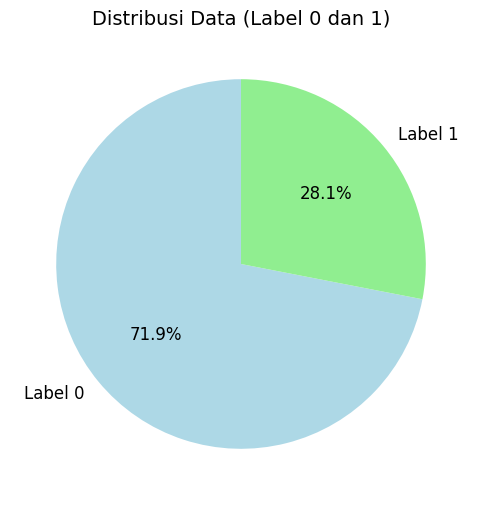

In [ ]:
# Hitung distribusi label
label_counts = result_df['label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=["Label 0", "Label 1"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightblue", "lightgreen"],
    textprops={"fontsize": 12}
)
plt.title("Distribusi Data (Label 0 dan 1)", fontsize=14)
plt.show()

# AUGMENTASI DATA

#### Ganti Judul 2 lama dengan hasil parafrase

In [ ]:
url_lama = 'https://docs.google.com/spreadsheets/d/1YAuYZa_LFqxqOpiMgFr-imZRoiIaNSZGDscOvY30tb8/export?gid=1995114602&format=csv'

url_baru = 'https://docs.google.com/spreadsheets/d/1YAuYZa_LFqxqOpiMgFr-imZRoiIaNSZGDscOvY30tb8/export?gid=667662987&format=csv'

In [ ]:
df_lama = pd.read_csv(url_lama)
df_baru = pd.read_csv(url_baru)

In [ ]:
# Menggabungkan data lama dengan data baru berdasarkan ID
df_merged = pd.merge(df_lama, df_baru[['id', 'judul 2']], on='id', how='left', suffixes=('', '_new'))

In [ ]:
# Mengganti kolom 'judul_2' lama dengan yang baru
df_merged['judul 2'] = df_merged['judul 2_new'].fillna(df_merged['judul 2'])

In [ ]:
# Menghapus kolom 'judul_2_new' yang tidak lagi diperlukan
df_merged = df_merged.drop(columns=['judul 2_new'])

#### Hitung ulang similarity

In [ ]:
# Preprocess Ulang
df_merged['judul 1 processed'] = df_merged['judul 1'].apply(preprocess_text)
df_merged['judul 2 processed'] = df_merged['judul 2'].apply(preprocess_text)

In [ ]:
augmented_df = calculate_bertscore(df_merged)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/32 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/86 [00:00<?, ?it/s]

done in 14.13 seconds, 387.07 sentences/sec


#### Labeling

In [ ]:
# Labeling
augmented_df['label'] = augmented_df['F1'].apply(add_label)

In [ ]:
# Hitung total label 1 & 0
total_label_1 = len(augmented_df[augmented_df['label'] == 1])
total_label_0 = len(augmented_df[augmented_df['label'] == 0])

print('Total Label 1:', total_label_1)
print('\n===========\n')
print('Total Label 0:', total_label_0)

Total Label 1: 2532


Total Label 0: 2936


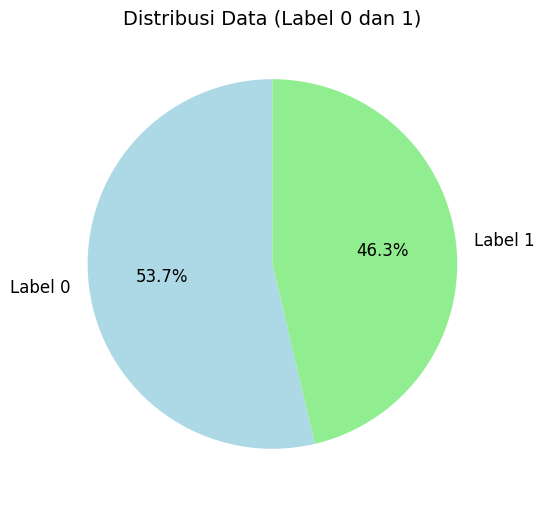

In [ ]:
# Hitung distribusi label
label_counts = augmented_df['label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=["Label 0", "Label 1"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightblue", "lightgreen"],
    textprops={"fontsize": 12}
)
plt.title("Distribusi Data (Label 0 dan 1)", fontsize=14)
plt.show()

In [ ]:
augmented_df.to_excel('DataFIXXX.xlsx')

# Scoring Judul Baru

In [ ]:
# URL dataset
judul_url = 'https://docs.google.com/spreadsheets/d/1YAuYZa_LFqxqOpiMgFr-imZRoiIaNSZGDscOvY30tb8/export?pli=1&gid=1190580499&format=csv'

judul_tersimpan_df = pd.read_csv(judul_url, usecols=['judul 1'])
# Remove Duplicates
judul_tersimpan_df = judul_tersimpan_df.drop_duplicates(subset=['judul 1'])

In [ ]:
# Load dataset
judul_lama_df = judul_tersimpan_df[:100].copy()

judul_baru_df = pd.read_csv(judul_url, usecols=['judul baru'])

In [ ]:
print(len(judul_baru_df))
print(len(judul_lama_df))

10000
100


In [ ]:
# Merge
combinations = list(product(judul_baru_df['judul baru'], judul_lama_df['judul 1']))

# Df baru
eval_baru_df = pd.DataFrame(combinations, columns=['judul baru', 'judul lama'])

# Drop data kosong
eval_baru_df = eval_baru_df.dropna(subset=['judul baru'])

In [ ]:
eval_baru_df

,judul baru,judul lama
0,Perencanaan Penerangan Jalan Umum Tenaga Surya...,analisis gangguan tidak seimbang pada jaring d...
1,Perencanaan Penerangan Jalan Umum Tenaga Surya...,analisis kegagalan operasi rele jarak pada sal...
2,Perencanaan Penerangan Jalan Umum Tenaga Surya...,analisis pengaruh pembebanan terhadap posisi p...
3,Perencanaan Penerangan Jalan Umum Tenaga Surya...,analisis pengaruh putaran rotor terhadap ayuna...
4,Perencanaan Penerangan Jalan Umum Tenaga Surya...,analisis pengurangan harmonik pada converter a...
...,...,...
995,sistem monitoring dan logging kadar sulfur dio...,perancangan home-page universitas tidar magela...
996,sistem monitoring dan logging kadar sulfur dio...,perancangan tapis aktif lolos piorde dua siste...
997,sistem monitoring dan logging kadar sulfur dio...,perencanaan hambatan standart dengan op-amp tr...
998,sistem monitoring dan logging kadar sulfur dio...,perencanaan sistem jaring komputer lokal pada ...


In [ ]:
# Preprocessing judul
eval_baru_df['judul lama preprocessed'] = eval_baru_df['judul lama'].apply(preprocess_text)
eval_baru_df['judul baru preprocessed'] = eval_baru_df['judul baru'].apply(preprocess_text)

In [ ]:
# Fungsi untuk memuat CSV dan menghitung BERTScore
def calculate_bertscore(df):

    # Ambil kolom "judul 1 processed" dan "judul 2 processed"
    cands = df['judul lama preprocessed'].tolist()
    refs = df['judul baru preprocessed'].tolist()

    # Hitung BERTScore
    P, R, F1 = score(cands,
                 refs,
                 lang="id",
                 verbose=True,
                 model_type='indobenchmark/indobert-large-p2',
                 num_layers= 24,
                 )

    # Masukkan nilai Precision, Recall, dan F1 ke dalam tabel
    df['Precision'] = P.numpy()
    df['Recall'] = R.numpy()
    df['F1'] = F1.numpy()

    return df

In [ ]:
scoring_eval_baru_df = calculate_bertscore(eval_baru_df)

calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 1.01 seconds, 992.46 sentences/sec


In [ ]:
# Labeling
scoring_eval_baru_df['label'] = scoring_eval_baru_df['F1'].apply(add_label)

In [ ]:
# Hitung total label 1 & 0
total_label_1 = len(scoring_eval_baru_df[scoring_eval_baru_df['label'] == 1])
total_label_0 = len(scoring_eval_baru_df[scoring_eval_baru_df['label'] == 0])

print('Total Label 1:', total_label_1)
print('\n===========\n')
print('Total Label 0:', total_label_0)

Total Label 1: 56


Total Label 0: 944


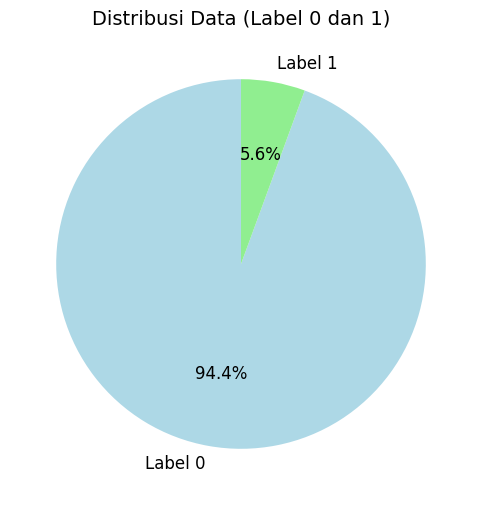

In [ ]:
# Hitung distribusi label
label_counts = scoring_eval_baru_df['label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=["Label 0", "Label 1"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["lightblue", "lightgreen"],
    textprops={"fontsize": 12}
)
plt.title("Distribusi Data (Label 0 dan 1)", fontsize=14)
plt.show()

In [ ]:
scoring_eval_baru_df.to_excel('scoring baru.xlsx')